<a href="https://colab.research.google.com/github/mathu3004/Pearl_Path/blob/Chatbot/ChatbotTestingCode_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch transformers datasets scikit-learn
!pip install datasets rouge-score



In [14]:
from datasets import Dataset

# Create a small dataset
data = {
    'query': [
        "What are the main attractions in Kandy?",
        "Which hotels are recommended in Colombo?",
        "What are the best restaurants in Nuwara Eliya?",
        "Where can I find emergency services in Ella?",
        "What are the popular tourist spots in Nuwara Eliya?",
        "Which restaurants are famous in Kandy?",
        "What are the top hotels in Ella?",
        "Where can I find emergency services in Colombo?"
    ],
    'context': [
        "The main attractions in Kandy include the Temple of the Tooth, Kandy Lake, and the Royal Botanical Gardens.",
        "Recommended hotels in Colombo are the Galle Face Hotel, Cinnamon Grand Colombo, and The Kingsbury.",
        "The best restaurants in Nuwara Eliya are The Grand Indian, Hill Club, and Grand Hotel.",
        "Emergency services in Ella can be found at Ella Hospital and the local police station.",
        "Popular tourist spots in Nuwara Eliya include Gregory Lake, Hakgala Botanical Garden, and Victoria Park.",
        "Famous restaurants in Kandy are The Empire Cafe, Kandy House Restaurant, and Theva Cuisine.",
        "Top hotels in Ella are 98 Acres Resort & Spa, Ella Jungle Resort, and The Secret Ella.",
        "Emergency services in Colombo are available at National Hospital of Sri Lanka and the Colombo Police Headquarters."
    ],
    'answer': [
        "Temple of the Tooth, Kandy Lake, Royal Botanical Gardens",
        "Galle Face Hotel, Cinnamon Grand Colombo, The Kingsbury",
        "The Grand Indian, Hill Club, Grand Hotel",
        "Ella Hospital, local police station",
        "Gregory Lake, Hakgala Botanical Garden, Victoria Park",
        "The Empire Cafe, Kandy House Restaurant, Theva Cuisine",
        "98 Acres Resort & Spa, Ella Jungle Resort, The Secret Ella",
        "National Hospital of Sri Lanka, Colombo Police Headquarters"
    ]
}

# Convert to a Dataset object
dataset = Dataset.from_dict(data)


Some weights of the model checkpoint at facebook/dpr-question_encoder-single-nq-base were not used when initializing DPRQuestionEncoder: ['question_encoder.bert_model.pooler.dense.bias', 'question_encoder.bert_model.pooler.dense.weight']
- This IS expected if you are initializing DPRQuestionEncoder from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DPRQuestionEncoder from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at facebook/dpr-ctx_encoder-single-nq-base were not used when initializing DPRContextEncoder: ['ctx_encoder.bert_model.pooler.dense.bias', 'ctx_encoder.bert_model.pooler.dense.weight']
- This IS expected if you are initializing DPRContextEncoder from the

Map:   0%|          | 0/6 [00:00<?, ? examples/s]

Map:   0%|          | 0/2 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: denuri-20230036 (denuri-20230036-robert-gordon-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Epoch,Training Loss,Validation Loss
1,No log,30.450397
2,No log,28.076925
3,No log,27.215313


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Exact Match Accuracy: 0.00%
Average BLEU Score: 0.01


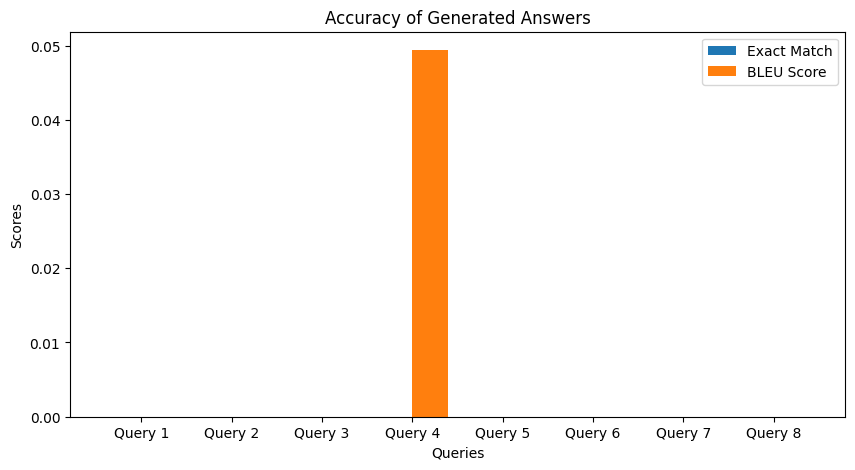

In [16]:
import torch
from transformers import DPRQuestionEncoder, DPRQuestionEncoderTokenizer, DPRContextEncoder, DPRContextEncoderTokenizer, T5ForConditionalGeneration, T5Tokenizer, Trainer, TrainingArguments
import numpy as np
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from datasets import Dataset

# Initialize DPR models and tokenizers
question_encoder = DPRQuestionEncoder.from_pretrained('facebook/dpr-question_encoder-single-nq-base')
question_tokenizer = DPRQuestionEncoderTokenizer.from_pretrained('facebook/dpr-question_encoder-single-nq-base')
context_encoder = DPRContextEncoder.from_pretrained('facebook/dpr-ctx_encoder-single-nq-base')
context_tokenizer = DPRContextEncoderTokenizer.from_pretrained('facebook/dpr-ctx_encoder-single-nq-base')

# Initialize T5 model and tokenizer
t5_model = T5ForConditionalGeneration.from_pretrained('t5-base')
t5_tokenizer = T5Tokenizer.from_pretrained('t5-base')

# Example queries and contexts related to Kandy, Colombo, Nuwara Eliya, and Ella
queries = [
    "What are the main attractions in Kandy?",
    "Which hotels are recommended in Colombo?",
    "What are the best restaurants in Nuwara Eliya?",
    "Where can I find emergency services in Ella?",
    "What are the popular tourist spots in Nuwara Eliya?",
    "Which restaurants are famous in Kandy?",
    "What are the top hotels in Ella?",
    "Where can I find emergency services in Colombo?"
]
contexts = [
    "The main attractions in Kandy include the Temple of the Tooth, Kandy Lake, and the Royal Botanical Gardens.",
    "Recommended hotels in Colombo are the Galle Face Hotel, Cinnamon Grand Colombo, and The Kingsbury.",
    "The best restaurants in Nuwara Eliya are The Grand Indian, Hill Club, and Grand Hotel.",
    "Emergency services in Ella can be found at Ella Hospital and the local police station.",
    "Popular tourist spots in Nuwara Eliya include Gregory Lake, Hakgala Botanical Garden, and Victoria Park.",
    "Famous restaurants in Kandy are The Empire Cafe, Kandy House Restaurant, and Theva Cuisine.",
    "Top hotels in Ella are 98 Acres Resort & Spa, Ella Jungle Resort, and The Secret Ella.",
    "Emergency services in Colombo are available at National Hospital of Sri Lanka and the Colombo Police Headquarters."
]
ground_truth_answers = [
    "Temple of the Tooth, Kandy Lake, Royal Botanical Gardens",
    "Galle Face Hotel, Cinnamon Grand Colombo, The Kingsbury",
    "The Grand Indian, Hill Club, Grand Hotel",
    "Ella Hospital, local police station",
    "Gregory Lake, Hakgala Botanical Garden, Victoria Park",
    "The Empire Cafe, Kandy House Restaurant, Theva Cuisine",
    "98 Acres Resort & Spa, Ella Jungle Resort, The Secret Ella",
    "National Hospital of Sri Lanka, Colombo Police Headquarters"
]

# Create a small dataset
data = {
    'query': queries,
    'context': contexts,
    'answer': ground_truth_answers
}

# Convert to a Dataset object
dataset = Dataset.from_dict(data)

# Split the dataset into training and validation sets
train_test_split = dataset.train_test_split(test_size=0.2)
train_dataset = train_test_split['train']
val_dataset = train_test_split['test']

# Define preprocessing function
def preprocess_function(examples):
    inputs = [f"question: {q} context: {c}" for q, c in zip(examples["query"], examples["context"])]
    targets = examples["answer"]

    model_inputs = t5_tokenizer(inputs, padding="max_length", truncation=True, max_length=512)
    labels = t5_tokenizer(targets, padding="max_length", truncation=True, max_length=128)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

# Apply preprocessing to datasets
train_dataset = train_dataset.map(preprocess_function, batched=True)
val_dataset = val_dataset.map(preprocess_function, batched=True)

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    num_train_epochs=3,
    weight_decay=0.01,
    remove_unused_columns=False  # Prevents dropping necessary columns
)

# Define the trainer
trainer = Trainer(
    model=t5_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

# Fine-tune the model
trainer.train()

# Encode queries and contexts using DPR
query_embeddings = question_encoder(**question_tokenizer(queries, return_tensors='pt', padding=True, truncation=True)).pooler_output
context_embeddings = context_encoder(**context_tokenizer(contexts, return_tensors='pt', padding=True, truncation=True)).pooler_output

# Compute similarity scores
similarity_scores = torch.matmul(query_embeddings, context_embeddings.t())

# Retrieve the most relevant context for each query
retrieved_contexts = [contexts[torch.argmax(similarity_scores[i]).item()] for i in range(len(queries))]

# Generate answers using the fine-tuned T5 model
generated_answers = []
for context in retrieved_contexts:
    input_text = f"answer: {context}"
    input_ids = t5_tokenizer(input_text, return_tensors='pt').input_ids
    output_ids = t5_model.generate(input_ids)
    answer = t5_tokenizer.decode(output_ids[0], skip_special_tokens=True)
    generated_answers.append(answer)

# Ensure consistent tokenization
def tokenize(text):
    return text.split()

# Ensure the generated answers are not empty
generated_answers = [answer if answer else "No answer generated" for answer in generated_answers]

# Evaluate accuracy using Exact Match and BLEU Score
exact_match = [int(tokenize(generated_answers[i]) == tokenize(ground_truth_answers[i])) for i in range(len(queries))]
bleu_scores = [sentence_bleu([tokenize(ground_truth_answers[i])], tokenize(generated_answers[i]), smoothing_function=SmoothingFunction().method1) for i in range(len(queries))]

# Print accuracy metrics
print(f"Exact Match Accuracy: {np.mean(exact_match) * 100:.2f}%")
print(f"Average BLEU Score: {np.mean(bleu_scores):.2f}")

# Visualize results
labels = ['Query 1', 'Query 2', 'Query 3', 'Query 4', 'Query 5', 'Query 6', 'Query 7', 'Query 8']
x = np.arange(len(labels))

plt.figure(figsize=(10, 5))
plt.bar(x - 0.2, exact_match, 0.4, label='Exact Match')
plt.bar(x + 0.2, bleu_scores, 0.4, label='BLEU Score')
plt.xlabel('Queries')
plt.ylabel('Scores')
plt.title('Accuracy of Generated Answers')
plt.xticks(x, labels)
plt.legend()
plt.show()
